In [1]:
#hide
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Conv2DTranspose
from keras.layers import LeakyReLU

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

num_classes = 10
img_rows, img_cols = 28, 28
latent_size = 128

Using TensorFlow backend.


In [2]:
#hide
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [3]:
def make_gen():
    model = Sequential()
    model.add(Dense(7 *7 * 10, input_dim=latent_size, activation='relu'))
#    model.add(Dense(7 * 7 * 10))
#    model.add(LeakyReLU(alpha=0.1))

    model.add(Reshape((7,7,10)))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(16, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(1, kernel_size=(5,5), strides=(1,1),
                              activation='sigmoid', padding='same'))
    return model
    

In [4]:
gen=make_gen()


Shape:  (1, 28, 28, 1)


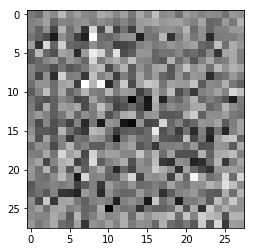

In [5]:
# untrained generator image
x=gen.predict(np.random.rand(1,latent_size))
print("Shape: ", x.shape)
plt.imshow(x[0].reshape(28,28), cmap='gray_r')
plt.show()

In [6]:
def make_desc():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3),
                     input_shape=(28,28,1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
#    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.1))
#    model.add(BatchNormalization())
#    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [7]:
desc=make_desc()

In [8]:
desc.predict(x_train[0:10])

array([[0.50258076],
       [0.5026674 ],
       [0.5030523 ],
       [0.50402117],
       [0.49682888],
       [0.5027407 ],
       [0.49726796],
       [0.5022461 ],
       [0.49910846],
       [0.50299037]], dtype=float32)

In [9]:
desc.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
desc._make_train_function()


In [10]:
def gen_fake_images(gen, n):
    noise = np.random.normal(size=(n, latent_size))
    return gen.predict(noise)

def train_desc_on_gen(gen, desc):
    batch_size = 100
    imgs = gen_fake_images(gen, batch_size)
    desc.train_on_batch(imgs, np.zeros(batch_size).reshape(batch_size,1))

In [11]:
def train_desc_on_real(desc, imgs):
    desc.train_on_batch(imgs, 0.9*np.ones(len(imgs)).reshape(len(imgs),1))

In [12]:
def eval_desc(desc):
    print("Evaluating descriminator for real images")
    ev=desc.evaluate(x_train, np.ones(len(x_train)), 500)
    print("Evaluation: ", ev)
    print("Evaluating generator")
    fake_imgs = gen_fake_images(gen, 500)
    ev=desc.evaluate(fake_imgs, np.ones(len(fake_imgs)))
    print("Evaluation: ", ev)
    

In [13]:
latent = Input(shape=(latent_size, ))
desc.trainable = False
combined = Model(latent, desc(gen(latent)))
combined.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [14]:
def train_gen(combined):
    batch_size = 100
    noise = np.random.normal(size=(batch_size, latent_size))
    combined.train_on_batch(noise, 0.95*np.ones((batch_size,1)))


In [15]:
def plot_gen(gen, rows, cols):
    h = img_cols
    w = img_rows
    out = np.zeros((rows*h, cols*w), dtype='f')
    i = 0
    imgs=gen_fake_images(gen, rows*cols)
    for r in range(rows):
        for c in range(cols):
            x_off = c*w
            y_off = r*h
            if i < len(imgs): out[y_off:y_off+h,x_off:x_off+w] = imgs[i].squeeze()
            i+=1
    plt.imshow(out, cmap='gray_r')
    plt.show()

/home/rob/.local/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Evaluating descriminator for real images
60000/60000 [==============================] - 1s 16us/step
Evaluation:  [0.8675304373105367, 0.5433999973038832]
Evaluating generator
500/500 [==============================] - 0s 156us/step
Evaluation:  [2.5358531684875487, 0.052]


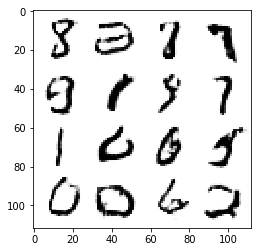

Evaluating descriminator for real images
60000/60000 [==============================] - 1s 14us/step
Evaluation:  [0.5675072088837624, 0.6953333313266437]
Evaluating generator
500/500 [==============================] - 0s 74us/step
Evaluation:  [2.276825428009033, 0.05400000005960465]


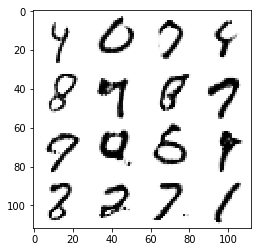

Evaluating descriminator for real images
60000/60000 [==============================] - 1s 13us/step
Evaluation:  [0.15155655381580194, 0.9778666680057844]
Evaluating generator
500/500 [==============================] - 0s 128us/step
Evaluation:  [1.072101728439331, 0.4020000002384186]


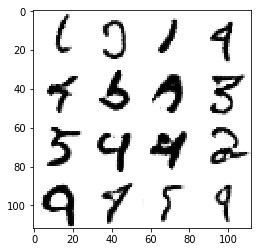

Evaluating descriminator for real images
60000/60000 [==============================] - 1s 14us/step
Evaluation:  [0.2975554518401623, 0.8990500008066495]
Evaluating generator
500/500 [==============================] - 0s 147us/step
Evaluation:  [1.4124257593154907, 0.21800000011920928]


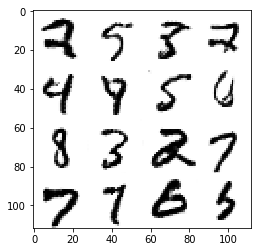

Evaluating descriminator for real images
60000/60000 [==============================] - 1s 13us/step
Evaluation:  [0.1897336844354868, 0.9688666671514511]
Evaluating generator
500/500 [==============================] - 0s 108us/step
Evaluation:  [0.966523063659668, 0.39599999952316284]


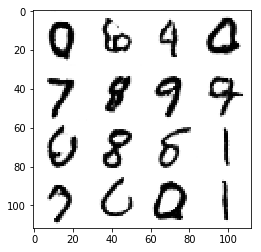

Evaluating descriminator for real images
60000/60000 [==============================] - 1s 13us/step
Evaluation:  [0.21978408445914585, 0.9658333351214726]
Evaluating generator
500/500 [==============================] - 0s 123us/step
Evaluation:  [1.0560314526557923, 0.36799999952316287]


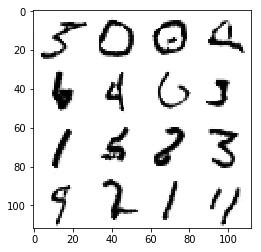

KeyboardInterrupt: 

In [16]:
batch_size=100
for epoch in range(50):
    offset_start = 0
    for step in range(1000):
        offset_start += batch_size
        if (offset_start + batch_size) >= len(x_train): offset_start = 0
        offset_end = offset_start + batch_size
        real_imgs = x_train[offset_start:offset_end]
        fake_imgs = gen_fake_images(gen, batch_size)
        real_img_targets = 0.95*np.ones(batch_size).reshape(batch_size,1)
        fake_img_targets = 0.05*np.ones(batch_size).reshape(batch_size,1)
#        imgs = np.concatenate((real_imgs, fake_imgs))
#        targets = np.concatenate((real_img_targets, fake_img_targets))
 #       desc.train_on_batch(imgs, targets)
        desc.train_on_batch(real_imgs, real_img_targets)
        desc.train_on_batch(fake_imgs, fake_img_targets)
        train_gen(combined)
        train_gen(combined)
    eval_desc(desc)
    plot_gen(gen,4,4)


In [ ]:
plot_gen(gen,5,5)